# House price prediction

In this project we will predict the housing prices.

We will use the following data set:  
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

## XGBoost

For this project we will use Extreme Gradient Boosting, a powerful and efficient machine learning algorithm used for both classification and regression tasks. It belongs to the family of gradient boosting algorithms, which combine the predictions of multiple weak learners (usually decision trees) to create a strong predictive model.

 XGBoost sequentially builds an ensemble of decision trees, with each tree correcting errors made by its predecessors. It minimizes a cost function through iterative optimization, employing regularization techniques like L1 and L2 regularization to control the complexity of individual trees and prevent overfitting. Utilizing gradient descent optimization, XGBoost updates model parameters iteratively to approach the minimum of the loss function. Tree pruning is employed to control tree depth, reducing overfitting and enhancing computational efficiency. XGBoost is highly scalable, designed for parallel processing, making it efficient for large datasets. It also handles missing values internally, eliminating the need for extensive imputation. The algorithm often incorporates k-fold cross-validation during training to assess model performance and ensure robustness. XGBoost provides feature importance scores, indicating the contribution of each feature in predictions. 


## Table of Contents

- [Load data](#load-data)
- [Inspect data](#inspect-data)
- [Clean and preprocessing](#clean-and-preprocessing)
- [EDA (Exploratory Data Analysis)](#eda)
- [Scale, map, encode, and transform](#scale-map-encode-and-transform)
- [Feature selection](#feature-selection)
- [Hyperparameters tuning](#hyperparameters-tuning)
- [Build model](#build-model)
- [Evaluate model](#evaluate-model)


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder, LeaveOneOutEncoder, MEstimateEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, explained_variance_score

## [Load data](#load-data)


In [2]:
relative_path_train = 'house-prices-advanced-regression-techniques/train.csv'
relative_path_test = 'house-prices-advanced-regression-techniques/test.csv'
path_train = os.path.join(os.getcwd(),relative_path_train)
path_test = os.path.join(os.getcwd(),relative_path_test)

df_train = pd.read_csv(path_train)
df_test =  pd.read_csv(path_test)

## [Inspect data](#inspect-data)

In [3]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print(df_test.shape)
print(df_train.shape)

(1459, 80)
(1460, 81)


In [6]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [7]:
def inspect(df_train):
    print(f'Rows: {df_train.shape[0]} Columns: {df_train.shape[1]}')
    print(f'Sum of missing values: {df_train.isna().sum().sum()}')

    col_names = df_train.columns
    dtypes = df_train.dtypes
    uniques = df_train.nunique()
    na_vals = df_train.isna().sum()

    print('%38s %10s     %10s %10s' % ('Column Name', 'Data Type', 'Distinct', 'Missing Val.'))
    
    for col_name in col_names:
        if df_train[col_name].isna().sum() > 0:
            print('%38s %10s   %10s %10s' % (col_name, dtypes[col_name], uniques[col_name], na_vals[col_name]))


In [8]:
inspect(df_train)

Rows: 1460 Columns: 81
Sum of missing values: 7829
                           Column Name  Data Type       Distinct Missing Val.
                           LotFrontage    float64          110        259
                                 Alley     object            2       1369
                            MasVnrType     object            3        872
                            MasVnrArea    float64          327          8
                              BsmtQual     object            4         37
                              BsmtCond     object            4         37
                          BsmtExposure     object            4         38
                          BsmtFinType1     object            6         37
                          BsmtFinType2     object            6         38
                            Electrical     object            5          1
                           FireplaceQu     object            5        690
                            GarageType     object        

## [Clean and preprocessing](#clean-and-preprocessing)


I want to see if there are any columns where there are over 80% of missing values. If this is the case we will drop them immidietly as they contain to little information. Only then we will think how to deal with other missing values.

In [9]:
# df_train.drop('Id', axis=1, inplace=True) # We could drop the id now but we may need it later. we will perform many operations often spliting and joining df. we may need indexes to check if the joint rows are synanomus

In [10]:
def val_fill_proportion(df_train):
    columns_to_drop = []
    missing_val_columns = []

    print('%-38s    %-10s' % ('Column Name', 'Percentage of filled values'))

    for column_name in df_train.columns:
        if df_train[column_name].isna().sum() > 0:
            missing_percent = (df_train[column_name].isna().sum() / df_train.shape[0]) * 100
            filled_percent = 100 - missing_percent
            print('%-38s    %-10.1f%%' % (column_name, filled_percent))

            if filled_percent < 80:
                columns_to_drop.append(column_name)
            elif filled_percent >= 80:
                missing_val_columns.append(column_name)

    return columns_to_drop, missing_val_columns  # Return the lists because i want to globaly use them, and not want to multiply the length of the list whenever i call function


In [11]:
columns_to_drop, missing_val_columns = val_fill_proportion(df_train)

Column Name                               Percentage of filled values
LotFrontage                               82.3      %
Alley                                     6.2       %
MasVnrType                                40.3      %
MasVnrArea                                99.5      %
BsmtQual                                  97.5      %
BsmtCond                                  97.5      %
BsmtExposure                              97.4      %
BsmtFinType1                              97.5      %
BsmtFinType2                              97.4      %
Electrical                                99.9      %
FireplaceQu                               52.7      %
GarageType                                94.5      %
GarageYrBlt                               94.5      %
GarageFinish                              94.5      %
GarageQual                                94.5      %
GarageCond                                94.5      %
PoolQC                                    0.5       %
Fence       

In [12]:
# missing_val_columns

In [13]:
# columns_to_drop

Ok now that we know how much information is in each column we can drop those belowe 80%

In [14]:
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_train.shape

(1460, 75)

In [15]:
val_fill_proportion(df_train)

Column Name                               Percentage of filled values
LotFrontage                               82.3      %
MasVnrArea                                99.5      %
BsmtQual                                  97.5      %
BsmtCond                                  97.5      %
BsmtExposure                              97.4      %
BsmtFinType1                              97.5      %
BsmtFinType2                              97.4      %
Electrical                                99.9      %
GarageType                                94.5      %
GarageYrBlt                               94.5      %
GarageFinish                              94.5      %
GarageQual                                94.5      %
GarageCond                                94.5      %


([],
 ['LotFrontage',
  'MasVnrArea',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'GarageType',
  'GarageYrBlt',
  'GarageFinish',
  'GarageQual',
  'GarageCond'])

In [16]:
# Now df_train only contains the columns that were not dropped
df_missing = df_train[missing_val_columns]

# we will look at the describe of missing columns - we will get info only on numerical columns
df_missing.describe()


,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


Based on above information we see that columns LotFrontage and GarageYrBlt have roughly symetric distribution (50% and mean are similar). We can use mean to fill the missing data here.

MasVnrArea is right-skewed (mean is greater than the median). We will use median then to fill missing data

In [17]:
# Columns with missing values
columns_to_fill_mean = ['LotFrontage', 'GarageYrBlt']
columns_to_fill_median = ['MasVnrArea']

# WE need to update our orginal df as well as df of missing values oin which we work to see what is left to do
# Filling missing values with mean for specified columns
df_missing.loc[:, columns_to_fill_mean] = df_missing.loc[:, columns_to_fill_mean].fillna(df_missing[columns_to_fill_mean].mean())
df_train.loc[:, columns_to_fill_mean] = df_train.loc[:, columns_to_fill_mean].fillna(df_train[columns_to_fill_mean].mean())

# Filling missing values with median for specified columns
df_missing.loc[:, columns_to_fill_median] = df_missing.loc[:, columns_to_fill_median].fillna(df_missing[columns_to_fill_median].median())
df_train.loc[:, columns_to_fill_median] = df_train.loc[:, columns_to_fill_median].fillna(df_train[columns_to_fill_median].median())


In [18]:
# List to hold the data for each column
stats = []

for column_name, dtype in df_missing.dtypes.items():
    if dtype == 'object':
        column_stats = {
            'column': column_name,
            'Distinct_value_incl_na': df_missing[column_name].nunique(),
            'Missing_values': df_missing[column_name].isna().sum(),
            'Percentage_missing': (df_missing[column_name].isna().sum() / len(df_missing)) * 100
        }
        stats.append(column_stats)


In [19]:
# Convert the list of dictionaries to a DataFrame
df_stats = pd.DataFrame(stats)
df_stats.head()

,column,Distinct_value_incl_na,Missing_values,Percentage_missing
0,BsmtQual,4,37,2.534247
1,BsmtCond,4,37,2.534247
2,BsmtExposure,4,38,2.602740
3,BsmtFinType1,6,37,2.534247
4,BsmtFinType2,6,38,2.602740


I want to check if missing values do not occur in the same rows. if it is so we can drop them.

In [20]:
# Displaying rows with missing values in specified columns
rows_with_missing_values = df_missing[df_missing[missing_val_columns].isnull().any(axis=1)]

In [21]:
rows_with_missing_values

,LotFrontage,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
17,72.000000,0.0,NaN,NaN,NaN,NaN,NaN,SBrkr,CarPort,1967.000000,Unf,TA,TA
39,65.000000,0.0,NaN,NaN,NaN,NaN,NaN,FuseP,NaN,1978.506164,NaN,NaN,NaN
48,33.000000,0.0,TA,TA,No,Unf,Unf,SBrkr,NaN,1978.506164,NaN,NaN,NaN
78,72.000000,0.0,TA,TA,No,Unf,Unf,SBrkr,NaN,1978.506164,NaN,NaN,NaN
88,105.000000,0.0,TA,Fa,No,Unf,Unf,SBrkr,NaN,1978.506164,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,70.049958,0.0,TA,TA,No,ALQ,Unf,SBrkr,NaN,1978.506164,NaN,NaN,NaN
1412,60.000000,0.0,NaN,NaN,NaN,NaN,NaN,FuseF,Detchd,1956.000000,Unf,TA,TA
1449,21.000000,0.0,Gd,TA,Av,GLQ,Unf,SBrkr,NaN,1978.506164,NaN,NaN,NaN
1450,60.000000,0.0,Gd,TA,No,Unf,Unf,SBrkr,NaN,1978.506164,NaN,NaN,NaN


Ok so i see that most of missing values overlaps so i will drop all of them because this is less then 10% of our data

In [22]:
# Assuming rows_with_missing_values contains the indices of the rows to drop
df_train = df_train.drop(rows_with_missing_values.index)

# Display the cleaned DataFrame
df_train.shape

(1346, 75)

In [23]:
val_fill_proportion(df_train)

Column Name                               Percentage of filled values


([], [])

In [24]:
df_train.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 75, dtype: int64

## [EDA (Exploratory Data Analysis)](#eda)


In [25]:
df_eda = df_train.copy()

In [26]:
df_eda['latest_contruction'] = df_eda[['YearBuilt', 'YearRemodAdd']].max(axis=1)

In [27]:
numerical_col = []
categorical_col = []

for column in df_eda.columns:
    if df_eda[column].dtype == 'object':
        categorical_col.append(column)
    else:
        numerical_col.append(column)

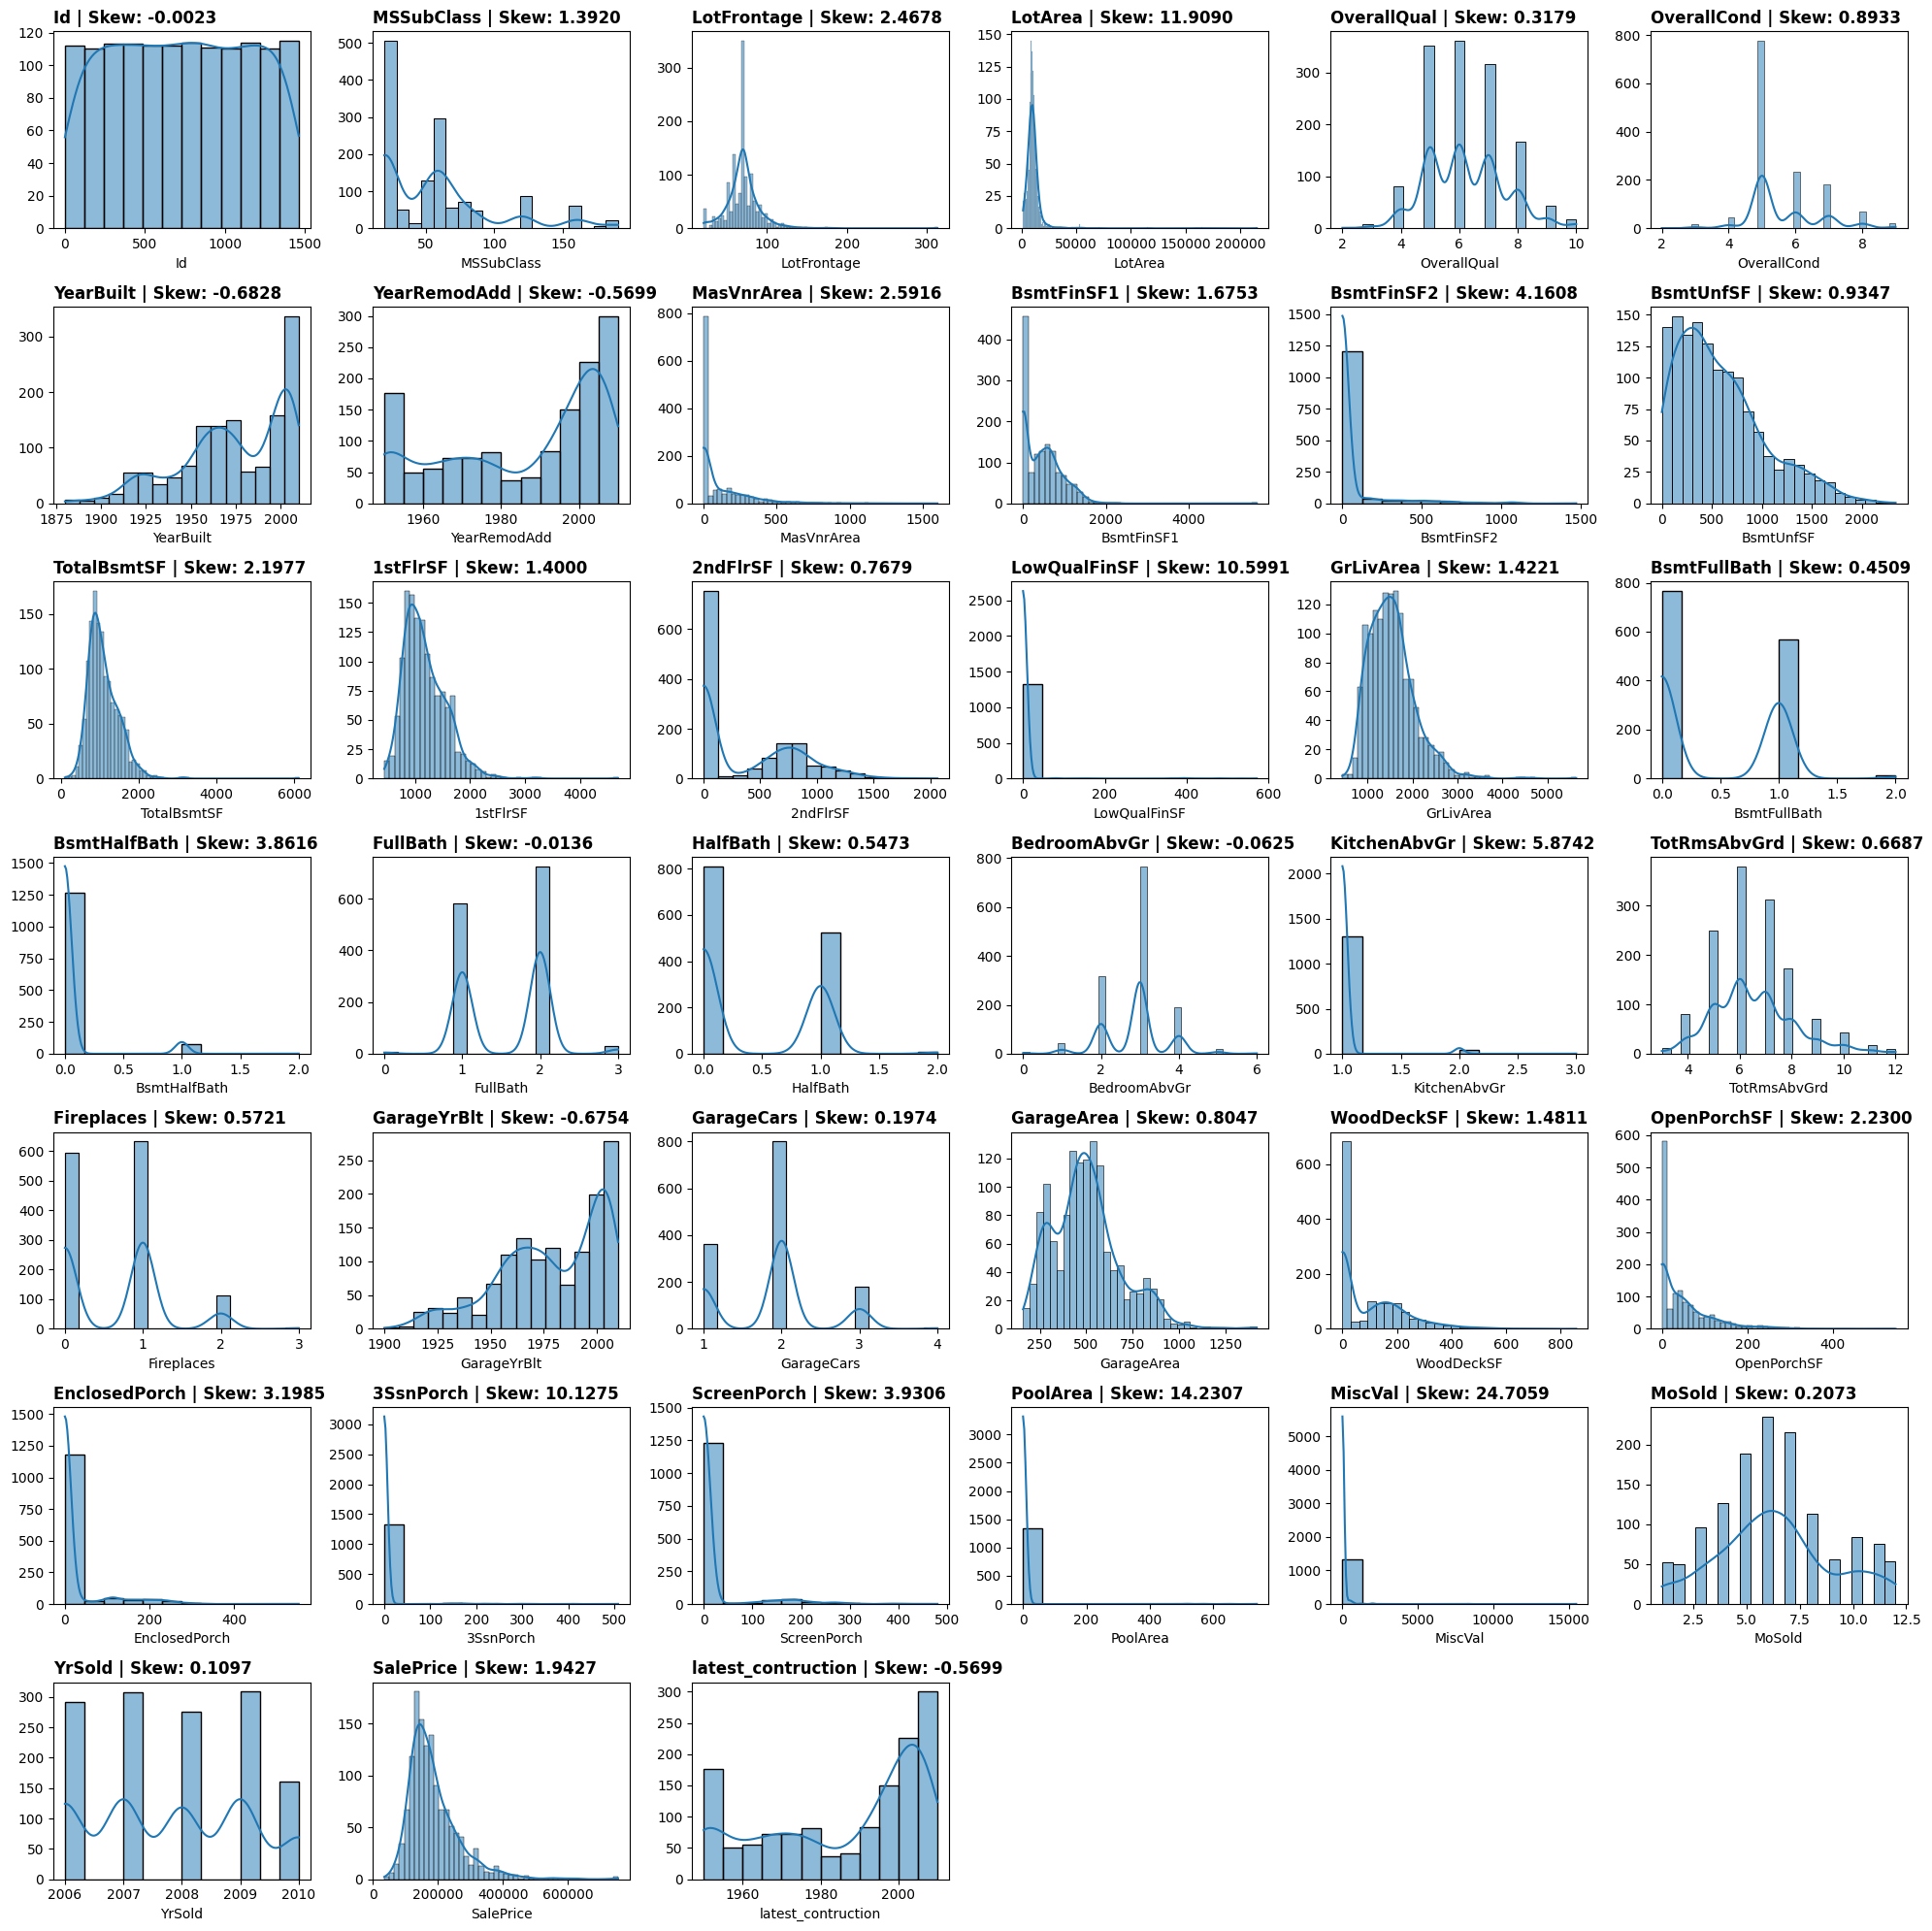

In [28]:
plt.figure(figsize=(20, 20))

# Determine the number of rows and columns dynamically
num_cols = 6
num_rows = (len(numerical_col) + num_cols - 1) // num_cols  # Ceiling division to ensure enough rows

for col in range(0, len(numerical_col)):
    plt.subplot(num_rows, num_cols, col + 1)
    sns.histplot(df_eda[numerical_col[col]], kde=True)
    plt.title(f"{numerical_col[col]} | Skew: {df_eda[numerical_col[col]].skew():.4f}", loc='left', weight='bold')
    plt.ylabel('')

plt.tight_layout()
plt.show()

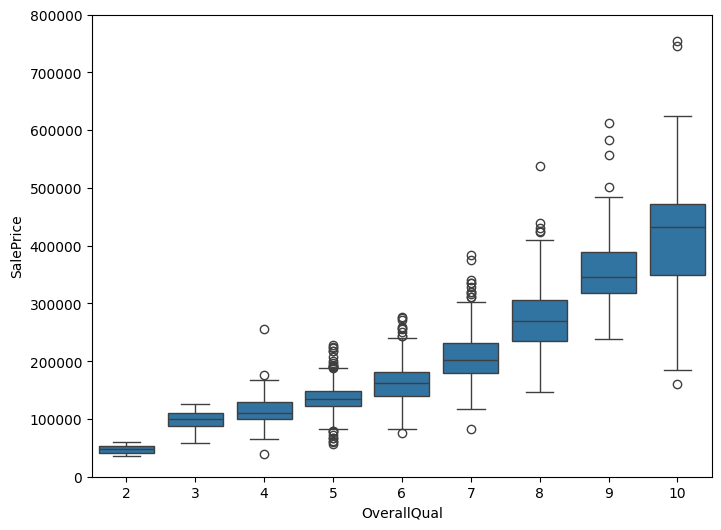

In [29]:
#box plot overallqual/saleprice
var = 'OverallQual'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=df_eda)
fig.axis(ymin=0, ymax=800000);

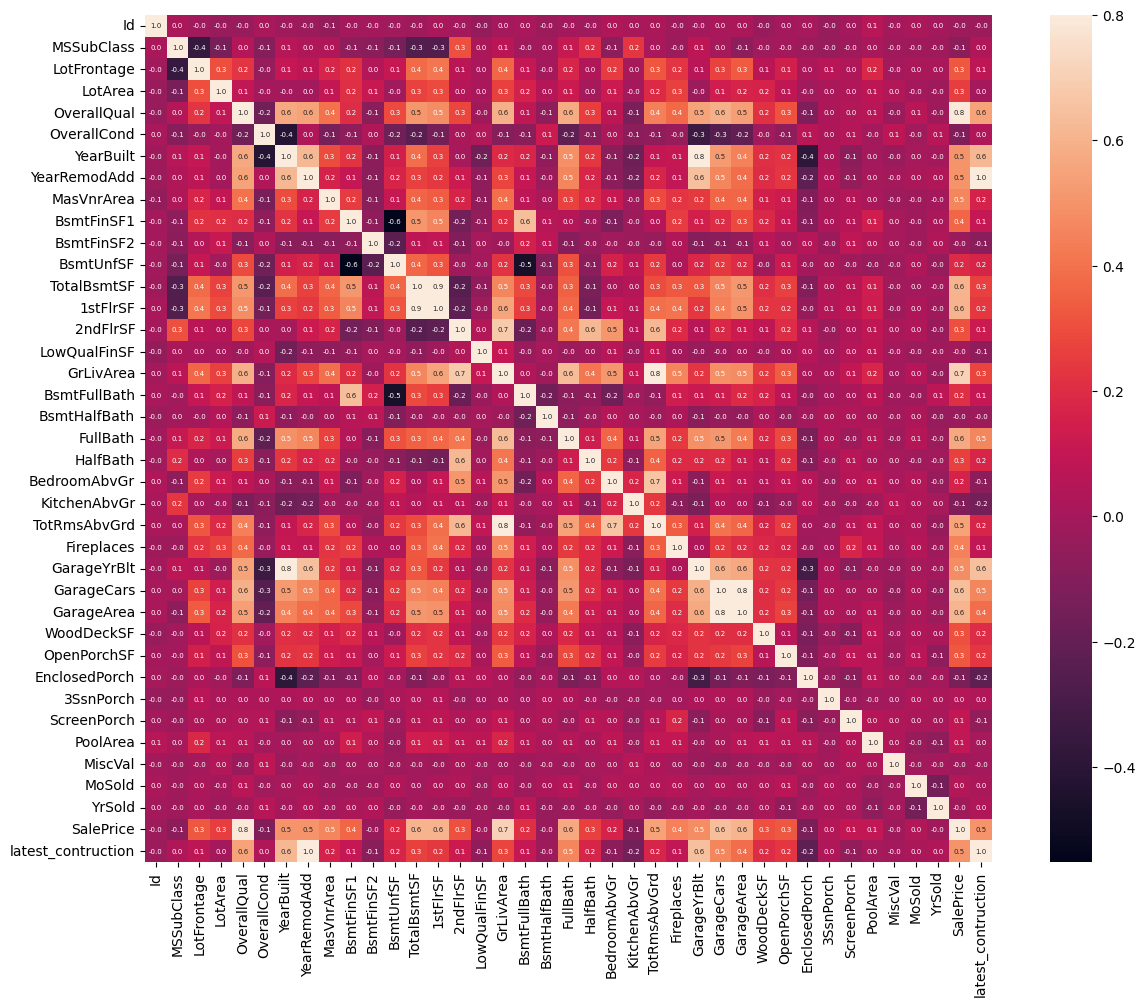

In [30]:
corr_matrix = df_eda[numerical_col].corr()

# Set the font size for annotations
annot_kws = {"size": 5}

# Set the format for the numbers (one decimal place)
fmt = ".1f"

f, ax = plt.subplots(figsize=(15, 11))
sns.heatmap(corr_matrix, annot=True, annot_kws=annot_kws, fmt=fmt, vmax=0.8, square=True)
plt.show()


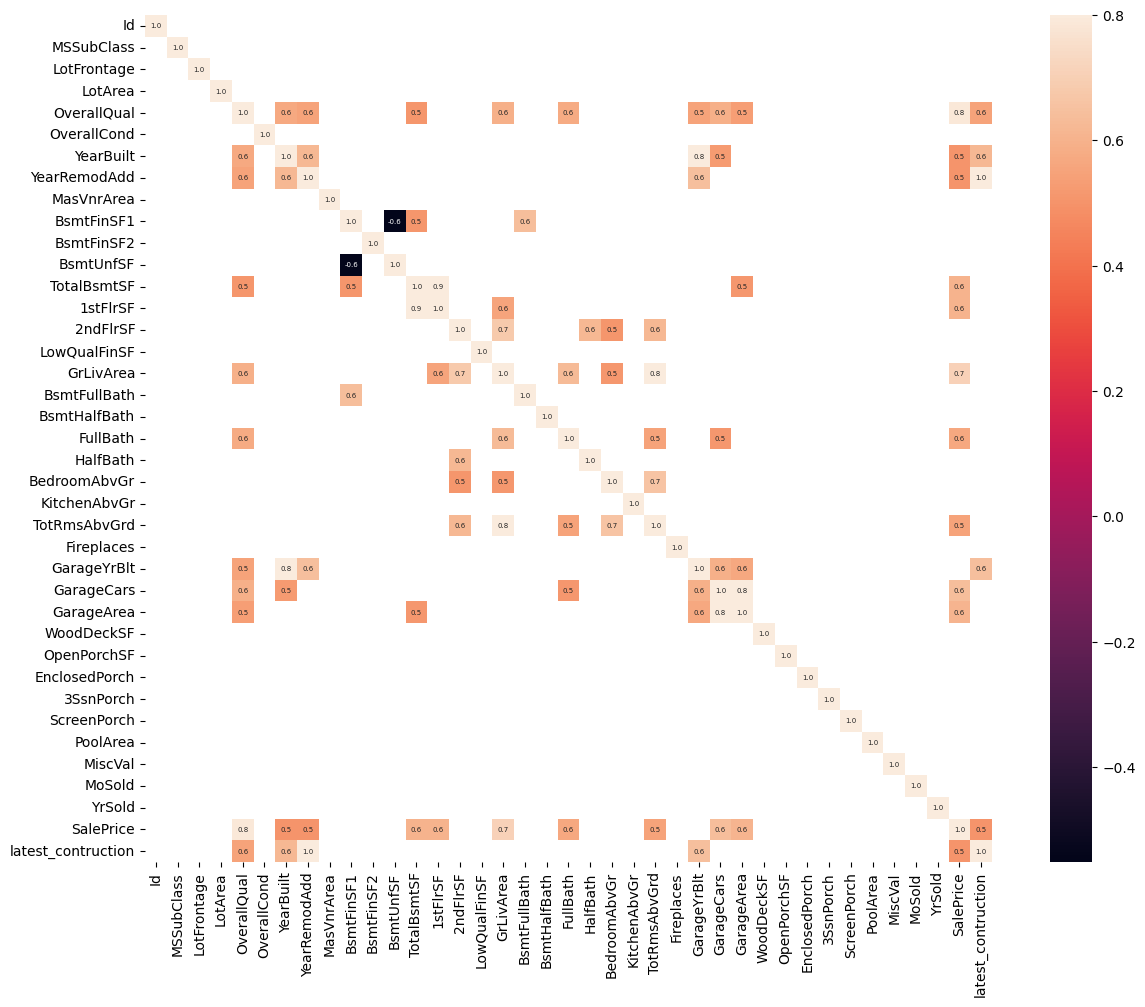

In [31]:
# Create a mask for correlations greater than 0.5 or less than -0.5
mask = (corr_matrix > 0.5) | (corr_matrix < -0.5)

# Applying the mask to the correlation matrix
masked_corr_matrix = corr_matrix[mask]

f, ax = plt.subplots(figsize=(15, 11))
sns.heatmap(masked_corr_matrix, annot=True, annot_kws=annot_kws, fmt=fmt, vmax=0.8, square=True)
plt.show()

In [32]:
corr_matrix = df_eda[numerical_col].corr()

# Set the threshold for correlation
threshold = 0.5

# Create an empty dictionary to store correlated columns
correlated_columns_dict = {}

# Iterate through each column
for column in corr_matrix.columns:
    # Find columns with correlations above the threshold
    correlated_columns = corr_matrix.index[(corr_matrix[column] > threshold) | (corr_matrix[column] < -threshold)].tolist()

    # Remove the current column from the list
    correlated_columns.remove(column)

    # Check if the list is not empty before adding to the dictionary
    if correlated_columns:
        correlated_columns_dict[column] = correlated_columns

In [33]:
for key, values in correlated_columns_dict.items():
    # Print the key
    print(key)

    # Print the values on the same line
    print(', '.join(values))

    # Print an empty line for better readability
    print()

OverallQual
YearBuilt, YearRemodAdd, TotalBsmtSF, GrLivArea, FullBath, GarageYrBlt, GarageCars, GarageArea, SalePrice, latest_contruction

YearBuilt
OverallQual, YearRemodAdd, GarageYrBlt, GarageCars, SalePrice, latest_contruction

YearRemodAdd
OverallQual, YearBuilt, GarageYrBlt, SalePrice, latest_contruction

BsmtFinSF1
BsmtUnfSF, TotalBsmtSF, BsmtFullBath

BsmtUnfSF
BsmtFinSF1

TotalBsmtSF
OverallQual, BsmtFinSF1, 1stFlrSF, GarageArea, SalePrice

1stFlrSF
TotalBsmtSF, GrLivArea, SalePrice

2ndFlrSF
GrLivArea, HalfBath, BedroomAbvGr, TotRmsAbvGrd

GrLivArea
OverallQual, 1stFlrSF, 2ndFlrSF, FullBath, BedroomAbvGr, TotRmsAbvGrd, SalePrice

BsmtFullBath
BsmtFinSF1

FullBath
OverallQual, GrLivArea, TotRmsAbvGrd, GarageCars, SalePrice

HalfBath
2ndFlrSF

BedroomAbvGr
2ndFlrSF, GrLivArea, TotRmsAbvGrd

TotRmsAbvGrd
2ndFlrSF, GrLivArea, FullBath, BedroomAbvGr, SalePrice

GarageYrBlt
OverallQual, YearBuilt, YearRemodAdd, GarageCars, GarageArea, latest_contruction

GarageCars
OverallQual, Yea

In [34]:
cor_target = abs(corr_matrix['SalePrice'])

relevant_features = cor_target
relevant_features.sort_values(ascending=False)

SalePrice             1.000000
OverallQual           0.784596
GrLivArea             0.710017
GarageCars            0.641109
GarageArea            0.608736
1stFlrSF              0.603505
TotalBsmtSF           0.602612
FullBath              0.567029
TotRmsAbvGrd          0.548900
YearBuilt             0.504132
YearRemodAdd          0.501153
latest_contruction    0.501153
GarageYrBlt           0.481825
MasVnrArea            0.460847
Fireplaces            0.443355
BsmtFinSF1            0.362246
LotFrontage           0.329520
OpenPorchSF           0.327406
2ndFlrSF              0.307796
WoodDeckSF            0.305896
HalfBath              0.260352
LotArea               0.253854
BsmtFullBath          0.211808
BsmtUnfSF             0.190390
BedroomAbvGr          0.165177
EnclosedPorch         0.127199
OverallCond           0.109916
KitchenAbvGr          0.109509
ScreenPorch           0.095076
PoolArea              0.091166
MSSubClass            0.081120
MoSold                0.042637
3SsnPorc

Now we will check which column withc we established have high impact on multicolinearity have low correlations scores. We will remove those columns. WE will use threshold of 0.35

In [35]:
least_corr = cor_target[abs(cor_target) < 0.35]
least_corr.sort_values(ascending=False)
dict_list = list(correlated_columns_dict.keys())

common_features = [feature for feature in least_corr.index if feature in dict_list]
print(common_features)
#print(least_corr)


['BsmtUnfSF', '2ndFlrSF', 'BsmtFullBath', 'HalfBath', 'BedroomAbvGr']


In [36]:
df_eda.drop(common_features, axis=1, inplace=True)

In [37]:
df_eda.shape

(1346, 71)

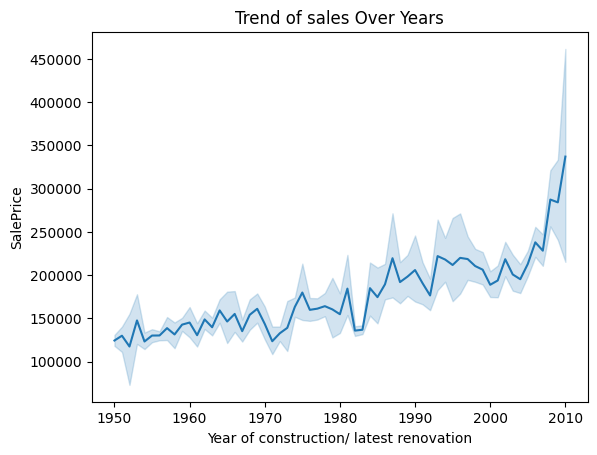

In [38]:
# Check the line graph for 'latest_contruction'

sns.lineplot(x='latest_contruction', y='SalePrice', data=df_eda)
plt.title('Trend of sales Over Years')
plt.xlabel('Year of construction/ latest renovation')
plt.ylabel('SalePrice')
plt.show()

(-0.5, 60.5, 0.0, 800000.0)

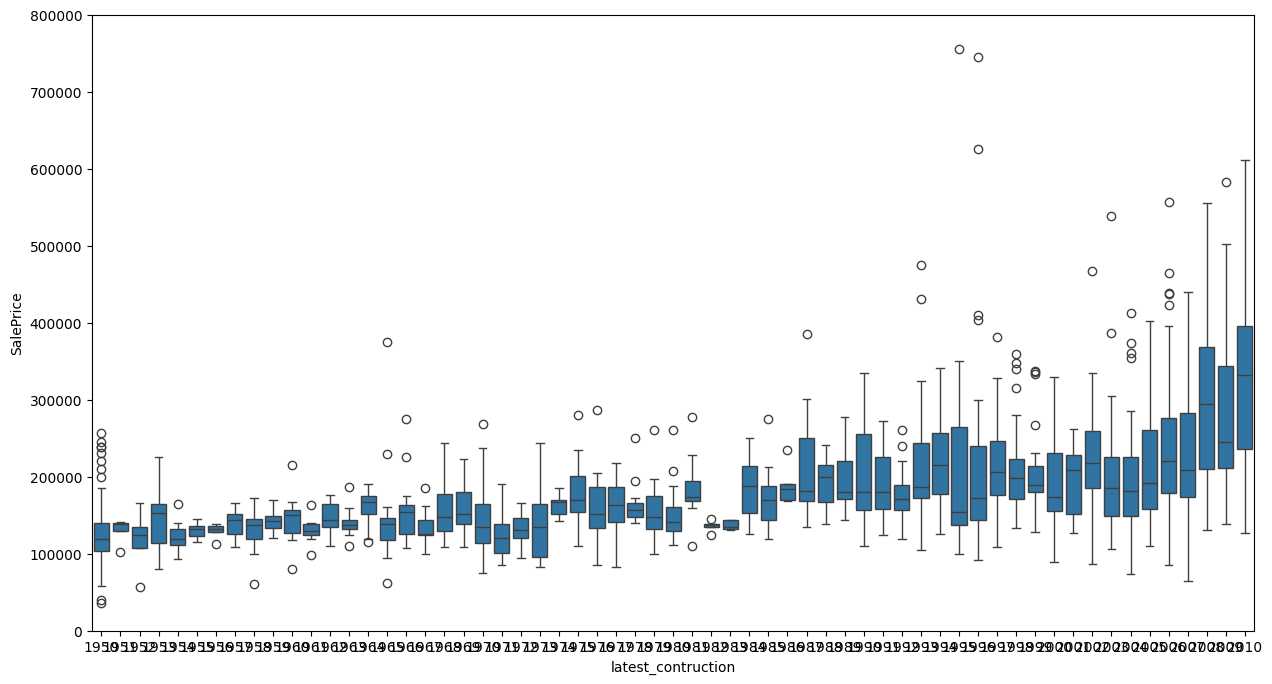

In [39]:
var = 'latest_contruction'
f, ax = plt.subplots(figsize=(15, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=df_eda)
fig.axis(ymin=0, ymax=800000)

## [Scale, map, encode, and transform](#scale-map-encode-and-transform)


### Encoding

WE will update a list of numerical and categorical columns.
We will then encode categorical columns.

Encoding is the process of converting categorical data into a numerical format that can be used for machine learning algorithms. Categorical data consists of labels or categories, such as color names or types of animals

In [40]:
# Updating list of numerical and categorical columns

numerical_col = []
categorical_col = []


for column in df_eda.columns:
    if df_eda[column].dtype == 'object':
        categorical_col.append(column)
    else:
        numerical_col.append(column)

In [41]:
len(categorical_col)

37

In [42]:
categorical_col

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [43]:
ordinal_col = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                'BsmtFinType2','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageFinish','GarageQual','GarageCond','PavedDrive','LotShape',
                'Utilities','LandSlope','BldgType','HouseStyle','LotConfig']
nominal_col = ['MSZoning', 'Street','LandContour','Neighborhood','Condition1','Condition2',
                'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Heating','GarageType','SaleType','SaleCondition', 'Foundation']

Nominal data comprises categories without any inherent order or ranking. For example types of fruits such as apple, banana, and orange. 
Ordinal data, on the other hand, represents categories with a meaningful order or rank. While it maintains information about relative order, the intervals between categories are not standardized. Examples of ordinal data include education levels (e.g., high school, college, graduate), customer satisfaction ratings (e.g., poor, satisfactory, excellent), or economic status (e.g., low income, middle income, high income). 

Both types require specific types of encoding, that preserves order or its lack. WE will use label encoding for ordinal data and on-hot-encoding for nominal data

In [44]:
df_encoded = df_eda

In [45]:
# Label encoding for ordinal columns
label_encoder = LabelEncoder()
for column in ordinal_col:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

# One-hot encoding for nominal columns
df_encoded = pd.get_dummies(df_encoded, columns=nominal_col, drop_first=True)

In [46]:
df_encoded.isna().sum().sum()

0

### Scaling  
  
Scaling is the process of transforming numerical features of different scales to a standard range, often between 0 and 1 or with a mean of 0 and a standard deviation of 1. Scaling is essential in many machine learning algorithms to ensure that all features contribute equally to the model, preventing features with larger scales from dominating the learning process.

In [47]:
scaler = StandardScaler()

df_target = df_encoded[['Id', 'SalePrice']]

df_independent = df_encoded
df_independent = df_independent.drop('SalePrice', axis=1)

In [48]:
# Scale the independent features
df_scaled = scaler.fit_transform(df_independent)

# Convert the scaled array back to a DataFrame
df_scaled = pd.DataFrame(df_independent, columns=df_independent.columns)

In [49]:
print(df_scaled.shape)
print(df_scaled.isna().sum().sum())

(1346, 167)
0


In [50]:
# Join back the scaled features and target feature
df_scaled['SalePrice'] = df_target['SalePrice']

In [51]:
print(df_scaled['SalePrice'].shape)
print(df_scaled['SalePrice'].isna().sum().sum())

(1346,)
0


In [52]:
print(df_scaled.shape)
print(df_scaled.isna().sum().sum())
print(np.isfinite(df_scaled).all().all())

(1346, 168)
0
True


In [53]:
df_scaled = df_scaled.drop('Id', axis=1)

### VIF

VIF is a statistical measure used in regression analysis to assess the extent of multicollinearity among independent variables. Multicollinearity occurs when predictors in a regression model are highly correlated, potentially leading to issues in interpreting the model's coefficients.

The primary goal of VIF is to quantify the degree of correlation between independent variables, helping us identify situations where this correlation might impact the reliability and stability of the regression model.

- A VIF of 1 indicates no correlation issues.
- VIF values exceeding 5 or 10 are often considered problematic, suggesting significant multicollinearity.

High VIF values can lead to inflated standard errors of regression coefficients, making it difficult to discern the true impact of each variable. This can compromise the reliability of the model's predictions and undermine its interpretability.

In [54]:
# Assuming df_scaled is your DataFrame
# Drop non-numeric columns, as VIF is applicable only to numeric data
numeric_df = df_scaled.select_dtypes(include=['float64', 'int64'])

# Calculate VIF for each column
X_with_constant = add_constant(numeric_df)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]

# Filter and display only columns with VIF larger than 5
high_vif_columns = vif_data[vif_data["VIF"] > 5]
print("Columns with VIF larger than 5:")
print(high_vif_columns)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Columns with VIF larger than 5:
              Variable           VIF
0                const  2.487217e+06
1           MSSubClass  5.526588e+00
12           YearBuilt  7.394801e+00
13        YearRemodAdd           inf
24         TotalBsmtSF  7.684967e+00
28            1stFlrSF  7.465434e+00
30           GrLivArea  7.430439e+00
54  latest_contruction           inf
55           SalePrice  5.999149e+00


In [55]:
col_to_remove = ['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']

df_scaled = df_scaled.drop(col_to_remove, axis=1)

## [Feature selection](#feature-selection)

XGBoost provides a built-in feature importance score based on how often each feature is used in the model and how much it improves the impurity. WE can access these scores using the feature_importances_ attribute after training the model.


## [Hyperparameters tuning](#hyperparameters-tuning)

- n_estimators
- early_stopping_rounds
- learning_rate
- n_jobs
- max_depth
- colsample_bytree

In [56]:
X = df_scaled.drop('SalePrice', axis=1)
y = df_scaled['SalePrice']

In [57]:
# Replace X and y with your actual data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split X_temp and y_temp into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [58]:
# Define the XGBoost regressor
xgb_model = XGBRegressor()

# Define hyperparameters to tune
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'alpha': [0, 1],
    'lambda': [0, 1]
}

In [59]:
"""
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
"""

'\ngrid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring=\'neg_mean_squared_error\')\ngrid_search.fit(X_train, y_train)\n\n# Get the best hyperparameters\nbest_params = grid_search.best_params_\nprint("Best Hyperparameters:", best_params)\n'

In [60]:
# Grid search takes long time so here i have stored output so i dont have to run it every time.
best_params = {'alpha': 0.0, 'colsample_bytree': 0.8, 'gamma': 0.0, 'lambda': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

##  [Build model](#build-model)

In [61]:
# Train the final model with the best hyperparameters
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)


XGBRegressor(alpha=0.0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1.0, learning_rate=0.1,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None, ...)

## [Evaluate model](#evaluate-model)

In [62]:
# Make predictions on the validation set
y_valid_pred = final_model.predict(X_valid)

# Calculate regression metrics for validation set
mae_valid = mean_absolute_error(y_valid, y_valid_pred)
r2_valid = r2_score(y_valid, y_valid_pred)
explained_variance_valid = explained_variance_score(y_valid, y_valid_pred)

print("Validation Set Metrics:")
print("Mean Absolute Error (MAE):", mae_valid)
print("R² Score:", r2_valid)
print("Explained Variance Score:", explained_variance_valid)
print("\n")

Validation Set Metrics:
Mean Absolute Error (MAE): 21274.94849537037
R² Score: 0.6054149782874283
Explained Variance Score: 0.6057303842564972




In [63]:
# Make predictions on the test set
y_test_pred = final_model.predict(X_test)

# Calculate regression metrics for test set
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
explained_variance_test = explained_variance_score(y_test, y_test_pred)

print("Test Set Metrics:")
print("Mean Absolute Error (MAE):", mae_test)
print("R² Score:", r2_test)
print("Explained Variance Score:", explained_variance_test)

Test Set Metrics:
Mean Absolute Error (MAE): 16697.85
R² Score: 0.8763773543962814
Explained Variance Score: 0.8767648380227802


The Mean Absolute Error measures the average absolute difference between the actual and predicted values. In this case, the MAE is approximately 18,986.4. On average, the model's predictions have an absolute deviation of around $18,986.4 from the actual values.

The R² score indicates the proportion of the variance in the target variable that is explained by the model. A score of 1.0 indicates a perfect fit, and a score of 0.0 indicates that the model does not explain the variance. The R² score of approximately 0.726 suggests that the model explains about 72.6% of the variance in the target variable. This is a decent fit, indicating that the model captures a significant portion of the variability in the data.

The Explained Variance Score measures the proportion of the variance in the target variable that the model is able to explain.

WE have seen that on the test set those metrics are even better.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=42)

model = XGBRegressor()
fit = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate regression metrics for test set
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
explained_variance_test = explained_variance_score(y_test, y_pred)

print("Test Set Metrics:")
print("Mean Absolute Error (MAE):", mae_test)
print("R² Score:", r2_test)
print("Explained Variance Score:", explained_variance_test)

Test Set Metrics:
Mean Absolute Error (MAE): 19683.58612295994
R² Score: 0.7283297153348549
Explained Variance Score: 0.728539016389703


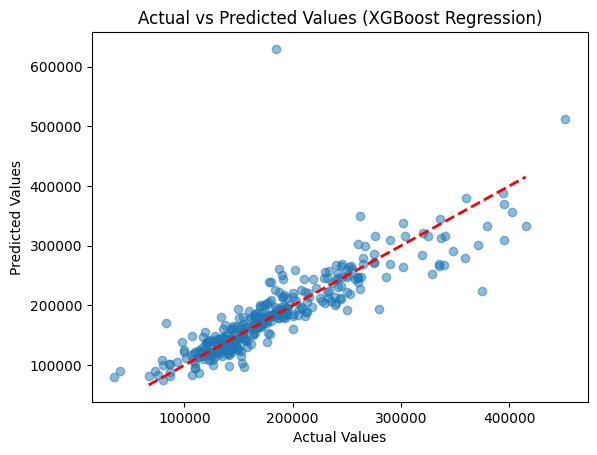

In [69]:
# Plotting the line created by the model
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (XGBoost Regression)")
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], '--', color='red', linewidth=2)
plt.show()